In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
import re

In [ ]:
df = pd.read_csv('../data/Questions.csv', encoding='ISO-8859-1')
df_answer = pd.read_csv('../data/Answers.csv', encoding='ISO-8859-1')

In [ ]:
df['all_text'] = df['Title'] + ' ' + df['Body']

In [ ]:
df= df[['Id','Score','all_text']]
df_answer = df_answer[['Id','ParentId','Score','Body']]

In [ ]:
def bad_question(score):
    if score < 0:
        return 1
    else:
        return 0

df['bad_question'] = df['Score'].apply(lambda x: bad_question(x))


In [ ]:
df_questions = df[['all_text', 'bad_question']]
train, test = train_test_split(df_questions, test_size=0.8, random_state=42)

In [ ]:
train_bad = train.loc[train['bad_question'] == 1]
train_good = train.loc[train['bad_question'] == 0]

In [ ]:
len(train_bad)

7261

In [ ]:
len(train_good)

114195

In [ ]:
good_sample = train_good.sample(frac=0.05)
train = good_sample.append(train_bad)

In [ ]:
df['all_text'].iloc[0]

"How can I find the full path to a font from its display name on a Mac? <p>I am using the Photoshop's javascript API to find the fonts in a given PSD.</p>\n\n<p>Given a font name returned by the API, I want to find the actual physical font file that that font name corresponds to on the disc.</p>\n\n<p>This is all happening in a python program running on OSX so I guess I'm looking for one of:</p>\n\n<ul>\n<li>Some Photoshop javascript</li>\n<li>A Python function</li>\n<li>An OSX API that I can call from python</li>\n</ul>\n"

In [ ]:
df['all_text'] = df['all_text'].apply(lambda x: re.sub('(\<code\>.*?<\/code\>)', '', x))

In [ ]:
df['all_text'] = df['all_text'].apply(lambda x: re.sub('<[^>]+>', '', x))

In [ ]:
df['all_text'].iloc[0]

"How can I find the full path to a font from its display name on a Mac? I am using the Photoshop's javascript API to find the fonts in a given PSD.\n\nGiven a font name returned by the API, I want to find the actual physical font file that that font name corresponds to on the disc.\n\nThis is all happening in a python program running on OSX so I guess I'm looking for one of:\n\n\nSome Photoshop javascript\nA Python function\nAn OSX API that I can call from python\n\n"

In [ ]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(train['all_text'])
X_train_counts.shape

(12971, 93793)

In [ ]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(12971, 96541)

In [ ]:


X_test_counts = count_vect.transform(test['all_text'])
X_test_tfidf = tfidf_transformer.fit_transform(X_test_counts)



NameError: name 'tfidf_transformer' is not defined

In [ ]:
clf = RandomForestClassifier(n_estimators = 5, n_jobs = -1, verbose=1, class_weight="balanced")
#clf = MLPClassifier(hidden_layer_sizes = (10, 10), verbose=True, early_stopping=True)
clf.fit(X_train_tfidf, train['bad_question'])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.8s finished


RandomForestClassifier(class_weight='balanced', n_estimators=5, n_jobs=-1,
                       verbose=1)

In [ ]:
y_pred = clf.predict(X_test_tfidf)
y_pred_train = clf.predict(X_train_tfidf)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.2s finished


In [ ]:
precision_recall_fscore_support(train['bad_question'], y_pred_train, average='macro')

(0.9623380524854306, 0.9596773868365458, 0.9608886470486635, None)

In [ ]:
precision_recall_fscore_support(test['bad_question'], y_pred, average='macro')

(0.5184336319052277, 0.5813119930533632, 0.3779575997619574, None)

In [ ]:


from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping



In [ ]:


X_train = train['all_text']
y_train = train['bad_question']
X_test = test['all_text']
y_test = test['bad_question']



In [ ]:


max_words = 2000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)



In [ ]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.9)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [ ]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 150)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 150, 50)           100000    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257   

In [ ]:
history = model.fit(sequences_matrix,y_train,batch_size=128,epochs=5,
          validation_split=0.2)

Epoch 1/20
386/386 [==============================] - 117s 299ms/step - loss: 0.6612 - accuracy: 0.6043 - val_loss: 0.7459 - val_accuracy: 0.4778
Epoch 2/20
386/386 [==============================] - 114s 296ms/step - loss: 0.6139 - accuracy: 0.6787 - val_loss: 0.6815 - val_accuracy: 0.6001
Epoch 3/20
386/386 [==============================] - 109s 281ms/step - loss: 0.6038 - accuracy: 0.6907 - val_loss: 0.5993 - val_accuracy: 0.7242
Epoch 4/20
386/386 [==============================] - 109s 284ms/step - loss: 0.5948 - accuracy: 0.6964 - val_loss: 0.5456 - val_accuracy: 0.7669
Epoch 5/20
386/386 [==============================] - 114s 296ms/step - loss: 0.5876 - accuracy: 0.6961 - val_loss: 0.5464 - val_accuracy: 0.7642
Epoch 6/20
386/386 [==============================] - 108s 281ms/step - loss: 0.5824 - accuracy: 0.7018 - val_loss: 0.6570 - val_accuracy: 0.6218
Epoch 7/20
386/386 [==============================] - 126s 327ms/step - loss: 0.5750 - accuracy: 0.7068 - val_loss: 0.5824 -

In [ ]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [ ]:


y_hat = model.predict(test_sequences_matrix, verbose = 1)



949/949 [==============================] - 28s 29ms/step


In [ ]:


y_hat[y_hat > 0.5] = 1
y_hat[y_hat <= 0.5] = 0
precision_recall_fscore_support(y_test, y_hat, average='macro')



(0.5327501386682802, 0.6408156064860984, 0.4607837105337105, None)

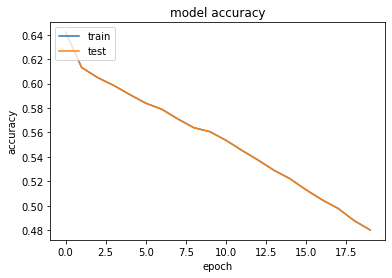

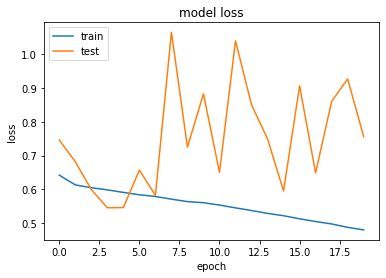

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3c29a683-71a2-405c-b0ad-9e789f7cae87' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>